## ========================= Performance =========================

### Terms
- **$N$:** Number of software threads.
- **$P$:** Number of compute units.
- **$T_P$:** Execution time using $P$ parallel compute units.
- **$T_{\infty}$:** Execution time when $P\rightarrow\infty$.
- **$T_{sec}$:** Sequential execution time. It refers to the time that takes to execute the parts of the program which are not parallelizable.
- **$T_{oh}$:** Overhead time. It refers to the extra computing time invested in tasks like creating and destroying threads, partitioning, copying and loading data for thread use, etc. 

Note that $N$ and $P$ are different concepts. If $N<P$ then some of the compute units remain idle during the computation. If $N=P$, each thread runs on a compute unit (hardware thread). If $N>P$, some threads will have to wait until a compute unit becomes available to execute them.<br>

### Performance metrics for parallelism
- **Span:** $T_{\infty}$. Execution time is the smallest when the maximum number of threads that can run the program simultaneously can do so on a separate compute unit: $P\rightarrow\infty$, then $T_P\geq T_{\infty}$.
- **Speedup:** $T_1/T_P$. At most, speedup grows linearly with $P$: $T_1/T_P=\Theta(P)$. 
- **Parallelism:** $T_1/T_\infty$. Is the maximum theoretical speedup.
- **Work:** $PT_P$. It is minimum when $P=1$, so $T_P\geq T_1/P$.
- **Efficiency:** $T_1/(PT_P)$. 


### Ahmdal's argument
Define the serial fraction:
$$\gamma=\frac{T_{sec}}{T_1},$$
then
$$T_P=T_{sec}+\frac{1}{P}(T_1-T_{sec})+T_{oh}$$
which, in terms of the serial fraction gives
$$T_P=T_1\left(\gamma+\frac{1}{P}(1-\gamma)+\gamma_{oh}\right),$$
where $\gamma_{oh}=T_{oh}/T_1$.<br>

This means that the speedup $S(P)$ when using $P$ computing units is
$$S(P)=\frac{1}{\gamma+(1-\gamma)/P+\gamma_{oh}}.$$
Lineal speedup is attained when $\gamma\rightarrow 0$ and $\gamma_{oh}\rightarrow 0$.<br>

#### Plotting the theoretical speedup
Here, $n$ represents the size of the problem. In the following plot, the size of both the sequential and parallel regions grows as $n$:

<img src="figures/speedup-1.png" width=600/>

In the next plot, the size of the sequential region remains constant while the size of the parallel region grows as $n$:

<img src="figures/speedup1-1.png" width=600/>

## ==================== Speedup experiment =====================

### Sequential program

<div class="alert alert-success">

`seq_add.py`
```python
from time import sleep, perf_counter

# Sequential vector addition
def vector_sum(v1, v2):
    try: 
        if len(v1) != len(v2):
            raise Exception('The two vectors do not have the same number of elements.')
        res = [0 for i in range(len(v1))]
        
        for i in range(len(v1)):
            sleep(delay)
            res[i] = v1[i] + v2[i]
            
        return res
    
    except Exception as error:
        print(error)
        
# Measure the average execution time of a sequential run
def seq_run(v1, v2, Ntrials):
    start_time = perf_counter()
    for i in range(Ntrials):
        res = vector_sum(v1,v2)
    end_time = perf_counter()
        
    return res, (end_time-start_time)/Ntrials
```
</div>

### Parallel program

<div class="alert alert-success">

`paral_add.py`
```python
from time import sleep, perf_counter
from threading import Thread

# Add vector's elements from ini to fin-1
def add(x, y, z, ini, fin):
    for i in range(ini, fin):
        sleep(delay)
        z[i] = x[i] + y[i]

# Parallelized vector addition
def par_vector_sum(v1, v2, n_thr):
    try: 
        if len(v1) != len(v2):
            raise Exception('The two vectors do not have the same number of elements.')
        res = [0 for i in range(len(v1))]
        
        n_thr = min(n_thr, len(v1)) #Number of threds <= length of the vectors
        
        chunk_size = len(v1) // n_thr + 1 #No. of tasks for each thread
        
        #Create the threads
        threads = []
        for i in range(n_thr):
            ini = i*chunk_size
            fin = min(ini + chunk_size, len(v1))
            threads.append(Thread(target=add, args=(v1, v2, res, ini, fin)))
        
        # Start the threads
        for thr in threads:
            thr.start()

        # Wait for the threads to complete
        for thr in threads:
            thr.join()
        return res, n_thr
    
    except Exception as error:
        print(error)
    
# Measure the average execution time of a parallel run
def par_run(v1, v2, Ntrials, n_thr):
    start_time = perf_counter()
    for i in range(Ntrials):
        res, n_thr = par_vector_sum(v1,v2,n_thr)
    end_time = perf_counter()
    
    return res, (end_time-start_time)/Ntrials
```
</div>

### Test

<div class="alert alert-success">

`example6.py`
```python
from seq_add import seq_run

# Sequential test

# Declare and initialize the input
sz = 1000
v1 = [1 for i in range(sz)]
v2 = [2 for i in range(sz)]

Ntrials = 100

res, seq_time = seq_run(v1, v2, Ntrials)

##Check result
assert res == [3 for i in range(sz)]

print("Secuential addition.")
print("Time: {0:.7f}".format(seq_time))
```
</div>

In [1]:
#!srun -N 1 -c 8 python3.10 code/example6.py
!python code/example6.py

Secuential addition.
Time: 0.0629405


<div class="alert alert-success">

`example7.py`
```python
from sys import argv
from paral_add import par_run

# Parallel test

code, seq_time = argv
seq_time = float(seq_time)

# Declare and initialize the input
sz = 1000
v1 = [1 for i in range(sz)]
v2 = [2 for i in range(sz)]

Ntrials = 100

#Number of threads
nt = 4
res, par_time = par_run(v1, v2, Ntrials, nt)

##Check result
assert res == [3 for i in range(sz)]

print("No. of threds: {0}".format(nt))
print("Time: {0:.7f}".format(par_time))
print("Speedup: {0:.3f}".format(seq_time/par_time))
```
</div>

In [2]:
#!srun -N 1 -c 8 python3.10 code/example7.py 0.0628672
!python code/example7.py 0.0628672

No. of threds: 4
Time: 0.0163581
Speedup: 3.843


### Plot speedup

<div class="alert alert-success">

`speedup.py`
```python
import matplotlib.pyplot as plt
from seq_add import seq_run
from paral_add import par_run
from matplotlib import rc
rc('text',usetex=True)

# Declare and initialize the input
sz = 1000
v1 = [1 for i in range(sz)]
v2 = [2 for i in range(sz)]
Ntrials = 100

#Perform the computations for  different number of cores
res, seq_time = seq_run(v1, v2, Ntrials)

speedups = []
procs = [i for i in range(1,7)]
for P in procs:
    res, par_time = par_run(v1, v2, Ntrials, P)
    speedups.append(seq_time/par_time)
```
</div>

In [3]:
#!srun -N 1 -c 8 python3.10 code/speedup.py
!python code/speedup.py

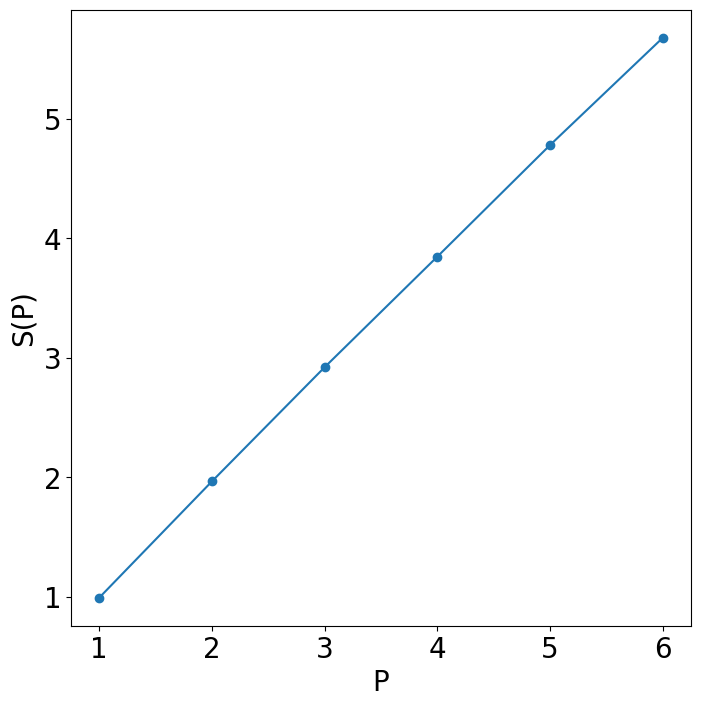

In [4]:
import matplotlib.pyplot as plt

#Load data
procs = []
speedups = []
with open("code/spdup_data.dat", "r") as ifile:
    for line in ifile:
        v = list(map(float, line.split()))
        procs.append(v[0])
        speedups.append(v[1])

#Plot data
fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax.plot(procs, speedups, marker='o')
ax.set_xlabel("P", fontsize=20)
ax.set_ylabel("S(P)", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)

---------------------------------------------